In [1]:
import os
import sys
spark_name = os.environ.get('SPARK_HOME',None)
if not spark_name:
    raise ValueErrorError('spark环境没有配置好')
sys.path.insert(0,os.path.join(spark_name,'python'))
sys.path.insert(0,os.path.join(spark_name,'python/lib/py4j-0.10.7-src.zip'))
exec(open(os.path.join(spark_name,'python/pyspark/shell.py')).read())
import findspark
findspark.init()
import pyspark
print("successful")

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.1
      /_/

Using Python version 3.9.12 (main, Apr  4 2022 05:22:27)
Spark context Web UI available at http://jelly:4042
Spark context available as 'sc' (master = local[*], app id = local-1671623668600).
SparkSession available as 'spark'.
successful


In [2]:
import findspark
findspark.init()
import pyspark
print("successful")
import warnings#忽略版本等警告
warnings.filterwarnings("ignore")

successful


In [3]:
from pyspark.sql import SparkSession
# 构建SparkSession执行环境入口对象
spark = SparkSession.builder. \
    appName('bigdata preana'). \
    master('local'). \
    getOrCreate()
sc = spark.sparkContext

In [4]:
dfread = spark.read.format('csv'). \
    option('sep', ','). \
        option('header', True). \
            option('encoding', 'GBK'). \
                load('D:\pycharm\pysparkProject_work\\bigdata_base\data\matches.csv',
                     inferSchema=True)
print('Total Records = {}'.format(dfread.count()))
dfread = dfread.selectExpr("_c0 as index","*").drop("_c0")

Total Records = 9226


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
dfread.show(5)

+-----+---+----------+----------+--------------+----------+-----------+---------------+----------+--------------+----------+-----------+---------------+------+
|index|win|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHerald|towerKills|inhibitorKills|baronKills|dragonKills|riftHeraldKills|region|
+-----+---+----------+----------+--------------+----------+-----------+---------------+----------+--------------+----------+-----------+---------------+------+
|    0|  0|         0|         0|             0|         0|          0|              0|         0|             0|         0|          0|              0|   na1|
|    1|  1|         1|         1|             0|         0|          1|              0|         1|             0|         0|          2|              0|   na1|
|    2|  0|         0|         0|             0|         0|          0|              0|         0|             0|         0|          0|              0|   na1|
|    3|  1|         1|         1|       

dataframe的列不好处理，转成Pandas分析

In [14]:
df = dfread.drop('win').drop('region').toPandas()
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)
scaled_data

array([[-1.73186308, -0.99913326, -0.99244131, ..., -0.62371444,
        -1.15938506, -0.94860297],
       [-1.73148761,  1.00086749,  1.00761626, ..., -0.62371444,
         0.33255811, -0.94860297],
       [-1.73111214, -0.99913326, -0.99244131, ..., -0.62371444,
        -1.15938506, -0.94860297],
       ...,
       [ 1.73111214,  1.00086749, -0.99244131, ...,  1.08992148,
         1.0785297 ,  0.40637628],
       [ 1.73148761,  1.00086749,  1.00761626, ...,  2.8035574 ,
         1.82450128, -0.94860297],
       [ 1.73186308, -0.99913326, -0.99244131, ..., -0.62371444,
        -0.41341347,  0.40637628]])

In [15]:
exp_var_ratio = []
for n in range(0,8):
    pca = PCA(n_components = n)
    pca.fit(scaled_data)
    pca.transform(scaled_data)
    exp_var_ratio.append(sum(pca.explained_variance_ratio_))

exp_var_ratio

[0,
 0.3711325291931783,
 0.5222827276244917,
 0.6249863766909862,
 0.7169140092860143,
 0.7983414196662131,
 0.8718622589889559,
 0.9191467963276541]

Text(0, 0.5, 'Ratio of Variance Explained')

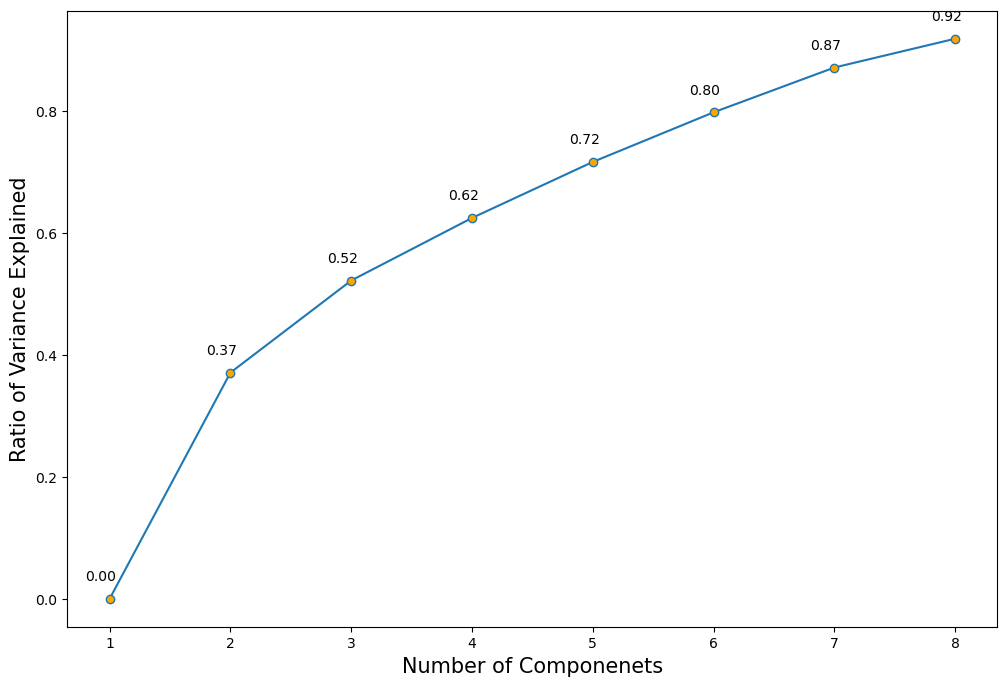

In [17]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.plot(range(1,9), exp_var_ratio, marker = 'o', markerfacecolor = 'orange', markersize = 6)
for i,j in zip(range(1,9),exp_var_ratio):
    ax.annotate('{:.2f}'.format(j),xy=(i-.2,j+.03))
plt.xlabel('Number of Componenets', size = 15)
plt.ylabel('Ratio of Variance Explained', size = 15)

<AxesSubplot:>

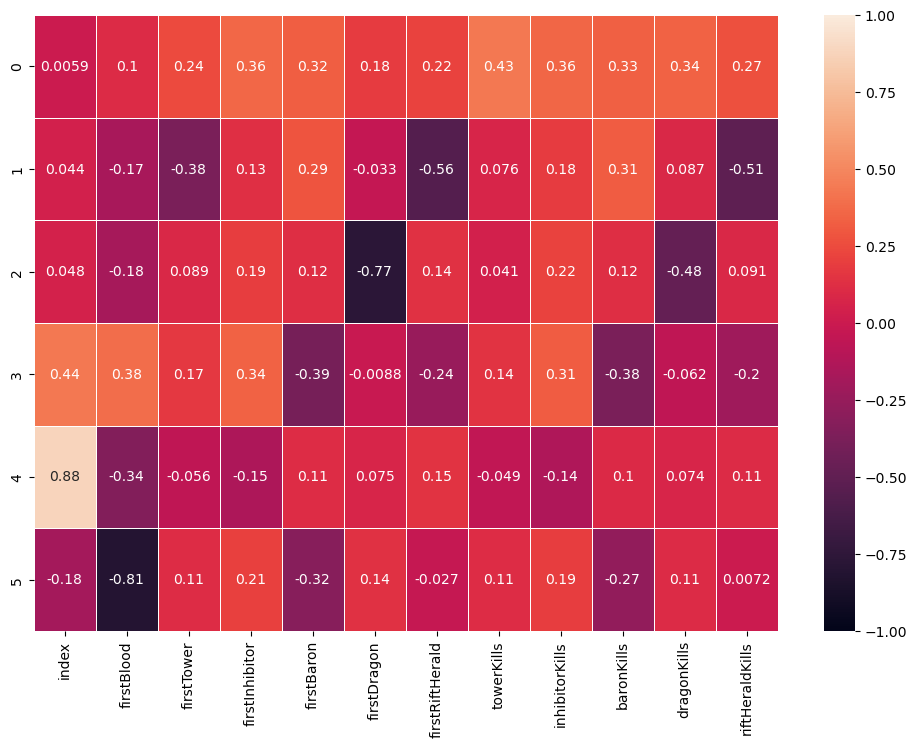

In [35]:
import seaborn as sns
import pandas as pd
pca = PCA(n_components = 6)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)
match_df = dfread.toPandas()
pca_corr = pd.DataFrame(pca.components_, columns = match_df.drop(['win', 'region'], axis = 1).columns)

plt.figure(figsize = (12,8))
sns.heatmap(pca_corr,  vmin = -1, vmax = 1, annot = True, lw = .5, linecolor = 'white')

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

逻辑回归

In [42]:

X = match_df.drop(['win', 'region'], axis = 1)
y = match_df.win

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

log = LogisticRegression()
log.fit(X_train, y_train)
y_pred = log.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print()

log_coeff_tot = pd.Series(log.coef_[0], index = match_df.drop(['win', 'region'], axis = 1).columns)
print(log_coeff_tot)

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1360
           1       0.89      0.83      0.86      1408

    accuracy                           0.86      2768
   macro avg       0.86      0.86      0.86      2768
weighted avg       0.86      0.86      0.86      2768

[[1215  145]
 [ 238 1170]]

index             -0.000098
firstBlood         0.022689
firstTower         0.893513
firstInhibitor     1.087886
firstBaron         0.094260
firstDragon        0.217383
firstRiftHerald   -0.024516
towerKills         0.379747
inhibitorKills     0.741061
baronKills        -0.196438
dragonKills        0.146715
riftHeraldKills   -0.035132
dtype: float64


In [43]:
X = match_df[match_df.region == 'na1'].drop(['win', 'region'], axis = 1)
y = match_df[match_df.region == 'na1'].win

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

log = LogisticRegression()
log.fit(X_train, y_train)
y_pred = log.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print()

log_coeff_na = pd.Series(log.coef_[0], index = match_df.drop(['win', 'region'], axis = 1).columns)
print(log_coeff_na)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       284
           1       0.89      0.85      0.87       298

    accuracy                           0.87       582
   macro avg       0.87      0.87      0.87       582
weighted avg       0.87      0.87      0.87       582

[[254  30]
 [ 46 252]]

index             -0.000039
firstBlood         0.307773
firstTower         1.310732
firstInhibitor     1.331251
firstBaron         0.122630
firstDragon        0.697298
firstRiftHerald   -0.170320
towerKills         0.418017
inhibitorKills     0.848805
baronKills        -0.578585
dragonKills        0.244195
riftHeraldKills   -0.131832
dtype: float64


In [44]:
X = match_df[match_df.region == 'br1'].drop(['win', 'region'], axis = 1)
y = match_df[match_df.region == 'br1'].win

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

log = LogisticRegression()
log.fit(X_train, y_train)
y_pred = log.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print()

log_coeff_br = pd.Series(log.coef_[0], index = match_df.drop(['win', 'region'], axis = 1).columns)
print(log_coeff_br)

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       267
           1       0.84      0.79      0.82       288

    accuracy                           0.81       555
   macro avg       0.82      0.82      0.81       555
weighted avg       0.82      0.81      0.81       555

[[224  43]
 [ 60 228]]

index             -0.000468
firstBlood         0.280399
firstTower         1.092186
firstInhibitor     1.286329
firstBaron         0.265948
firstDragon        0.191116
firstRiftHerald    0.379472
towerKills         0.425155
inhibitorKills     0.368681
baronKills        -0.200551
dragonKills       -0.127123
riftHeraldKills   -0.461576
dtype: float64


In [45]:
X = match_df[match_df.region == 'kr'].drop(['win', 'region'], axis = 1)
y = match_df[match_df.region == 'kr'].win

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

log = LogisticRegression()
log.fit(X_train, y_train)
y_pred = log.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print()

log_coeff_kr = pd.Series(log.coef_[0], index = match_df.drop(['win', 'region'], axis = 1).columns)
print(log_coeff_kr)

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       295
           1       0.85      0.78      0.81       304

    accuracy                           0.82       599
   macro avg       0.82      0.82      0.82       599
weighted avg       0.82      0.82      0.82       599

[[253  42]
 [ 68 236]]

index             -0.000570
firstBlood         0.473258
firstTower         1.076918
firstInhibitor     0.922980
firstBaron        -0.178341
firstDragon        0.356483
firstRiftHerald    0.233211
towerKills         0.408813
inhibitorKills     0.646701
baronKills        -0.099602
dragonKills        0.368618
riftHeraldKills   -0.441067
dtype: float64


In [46]:
X = match_df[match_df.region == 'euw1'].drop(['win', 'region'], axis = 1)
y = match_df[match_df.region == 'euw1'].win

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

log = LogisticRegression()
log.fit(X_train, y_train)
y_pred = log.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print()

log_coeff_euw = pd.Series(log.coef_[0], index = match_df.drop(['win', 'region'], axis = 1).columns)
print(log_coeff_euw)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       252
           1       0.88      0.85      0.86       250

    accuracy                           0.87       502
   macro avg       0.87      0.87      0.87       502
weighted avg       0.87      0.87      0.87       502

[[222  30]
 [ 37 213]]

index             -0.000475
firstBlood         0.468171
firstTower         0.933579
firstInhibitor     1.121350
firstBaron         0.155389
firstDragon       -0.069355
firstRiftHerald    0.027299
towerKills         0.489585
inhibitorKills     0.711914
baronKills        -0.232451
dragonKills       -0.044061
riftHeraldKills   -0.196565
dtype: float64


In [47]:
X = match_df[match_df.region == 'eun1'].drop(['win', 'region'], axis = 1)
y = match_df[match_df.region == 'eun1'].win

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

log = LogisticRegression()
log.fit(X_train, y_train)
y_pred = log.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print()

log_coeff_eun = pd.Series(log.coef_[0], index = match_df.drop(['win', 'region'], axis = 1).columns)
print(log_coeff_eun)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       258
           1       0.87      0.83      0.85       274

    accuracy                           0.85       532
   macro avg       0.85      0.85      0.85       532
weighted avg       0.85      0.85      0.85       532

[[225  33]
 [ 47 227]]

index             -0.000364
firstBlood         0.116354
firstTower         0.145511
firstInhibitor     0.309769
firstBaron         0.007116
firstDragon       -0.003903
firstRiftHerald   -0.073720
towerKills         0.660556
inhibitorKills     0.313452
baronKills        -0.014973
dragonKills       -0.172414
riftHeraldKills   -0.069030
dtype: float64


In [48]:
win_conditions_dict = dict()
win_conditions_dict['overall'] = log_coeff_tot
# win_conditions_dict['na'] = log_coeff_na
# win_conditions_dict['br'] = log_coeff_br
# win_conditions_dict['kr'] = log_coeff_kr
# win_conditions_dict['euw'] = log_coeff_euw
# win_conditions_dict['eun'] = log_coeff_eun
# win_conditions = pd.DataFrame(win_conditions_dict)
win_conditions

,overall,na,br,kr,euw,eun
index,-0.000056,-0.000057,-0.000465,-0.000643,-0.000496,-0.000387
firstBlood,0.155285,0.352765,0.093045,0.472741,0.359047,0.439183
firstTower,0.949051,1.442339,1.233045,0.519728,1.129837,0.495924
firstInhibitor,1.149886,1.259752,1.441163,0.626625,1.482528,0.699291
firstBaron,0.062520,0.130073,0.181838,-0.257803,0.292176,0.146625
firstDragon,0.256334,0.774502,0.447680,0.153970,0.066093,0.291205
firstRiftHerald,0.079523,-0.108139,0.447263,0.039781,0.115502,-0.365775
towerKills,0.350033,0.462630,0.457028,0.431703,0.492825,0.567218
inhibitorKills,0.748038,0.716690,0.079818,0.788355,0.141359,0.428386
baronKills,-0.210058,-0.318264,0.011648,-0.279269,-0.358533,0.021375


<AxesSubplot:>

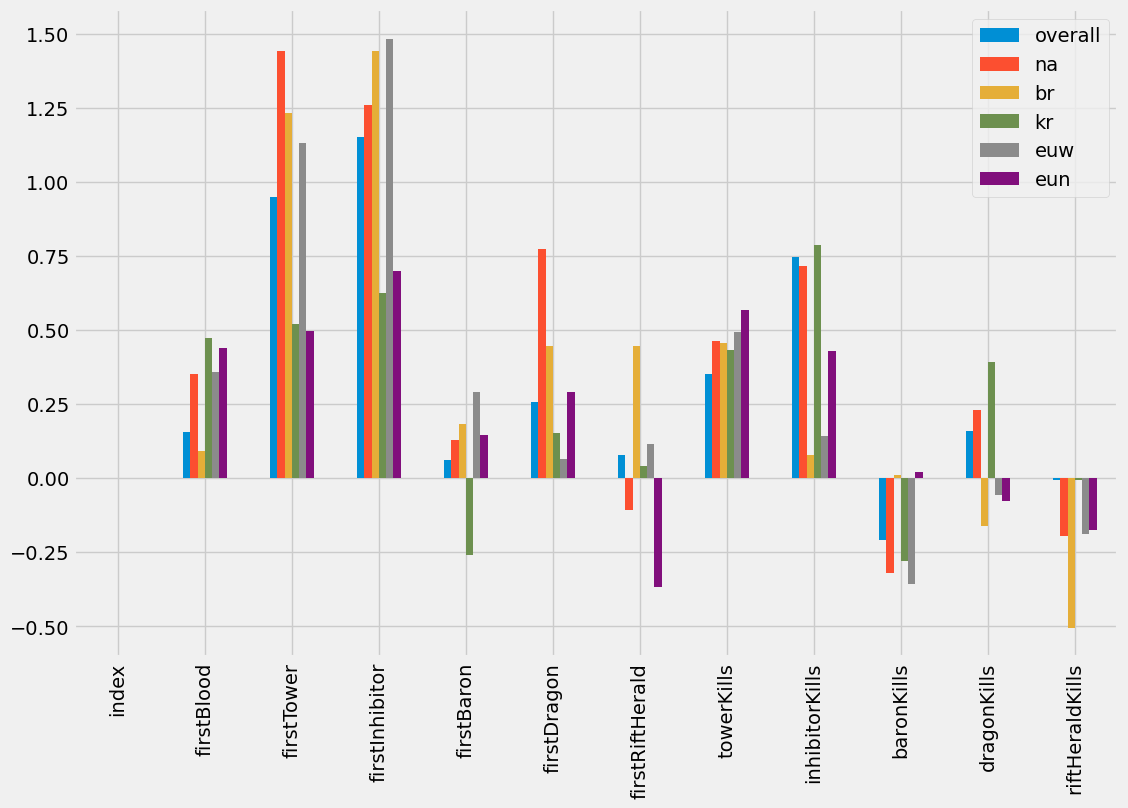

In [49]:
plt.style.use('fivethirtyeight')
win_conditions.plot(kind = 'bar', figsize = (12, 8))